In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 1.1 MB/s 


# Transformer
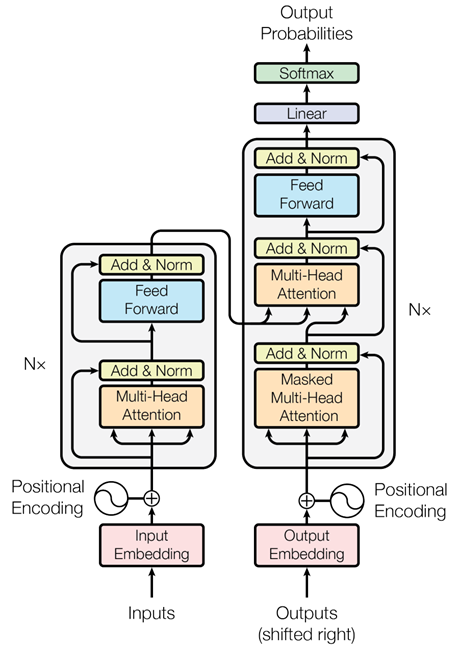

In [2]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## Positionwise Feed-Forward Networks

The positionwise feed-forward network
transforms
the representation at all the sequence positions
using the same MLP.
This is why we call it *positionwise*.
In the implementation below,
the input `X` with shape
[**batch size, number of time steps or sequence length in tokens, number of hidden units or feature dimension**]
will be transformed by a two-layer MLP into
an output tensor of shape
[**batch size, number of time steps, ffn_num_outputs**].


In [3]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

The following example
shows that [**the innermost dimension
of a tensor changes**] to
the number of outputs in
the positionwise feed-forward network.
Since the same MLP transforms
at all the positions,
when the inputs at all these positions are the same,
their outputs are also identical.


In [6]:
ffn = PositionWiseFFN(24, 48, 24)
ffn.eval()
ffn(torch.ones((64, 200, 24))).shape

torch.Size([64, 200, 24])

## Residual Connection and Layer Normalization

Now let us focus on
the "add & norm" component. This is a residual connection immediately
followed by layer normalization.
Both are key to effective deep architectures.

Recall batch normalization recenters and rescales across the examples within
a minibatch. Layer normalization is the same as batch normalization
except that the former normalizes across the feature dimension.

Despite its pervasive applications
in computer vision,
batch normalization
is usually empirically
less effective than layer normalization
in natural language processing
tasks, whose inputs are often
variable-length sequences.

The following code snippet
[**compares the normalization across different dimensions
by layer normalization and batch normalization**].

Refer to: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html


In [ ]:
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
X

tensor([[1., 2.],
        [2., 3.]])

In [ ]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
# Compute mean and variance from `X` in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


Now we can implement the `AddNorm` class
[**using a residual connection followed by layer normalization**].
Dropout is also applied for regularization.


In [10]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

The residual connection requires that
the two inputs are of the same shape
so that [**the output tensor also has the same shape after the addition operation**].


In [ ]:
add_norm = AddNorm([64, 200], 0.5)  # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((64, 64, 200)), torch.ones((64, 64, 200))).shape

torch.Size([64, 64, 200])

## Encoder

With all the essential components to assemble
the transformer encoder,
let us start by
implementing [**a single layer within the encoder**].
The following `EncoderBlock` class
contains two sublayers: multi-head self-attention and positionwise feed-forward networks,
where a residual connection followed by layer normalization is employed
around both sublayers.



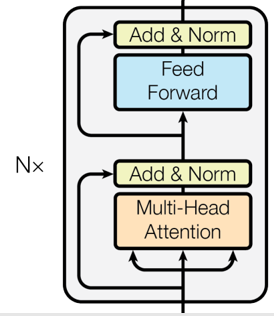

In [8]:
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

As we can see,
[**any layer in the transformer encoder
does not change the shape of its input.**]


In [23]:
X = torch.ones((64, 200, 24))
valid_lens = None #torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [200, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([64, 200, 24])

In the following [**transformer encoder**] implementation,
we stack `num_layers` instances of the above `EncoderBlock` classes.
Since we use the fixed positional encoding
whose values are always between -1 and 1,
we multiply values of the learnable input embeddings
by the square root of the embedding dimension
to rescale before summing up the input embedding and the positional encoding.


In [ ]:
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

Below we specify hyperparameters to [**create a two-layer transformer encoder**].
The shape of the transformer encoder output
is (batch size, number of time steps, `num_hiddens`).


In [ ]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## Decoder

As shown in :numref:`fig_transformer`,
[**the transformer decoder
is composed of multiple identical layers**].
Each layer is implemented in the following
`DecoderBlock` class,
which contains three sublayers:
decoder self-attention,
encoder-decoder attention,
and positionwise feed-forward networks.
These sublayers employ
a residual connection around them
followed by layer normalization.


As we described earlier in this section,
in the masked multi-head decoder self-attention
(the first sublayer),
queries, keys, and values
all come from the outputs of the previous decoder layer.
When training sequence-to-sequence models,
tokens at all the positions (time steps)
of the output sequence
are known.
However,
during prediction
the output sequence is generated token by token;
thus,
at any decoder time step
only the generated tokens
can be used in the decoder self-attention.
To preserve auto-regression in the decoder,
its masked self-attention
specifies  `dec_valid_lens` so that
any query
only attends to
all positions in the decoder
up to the query position.


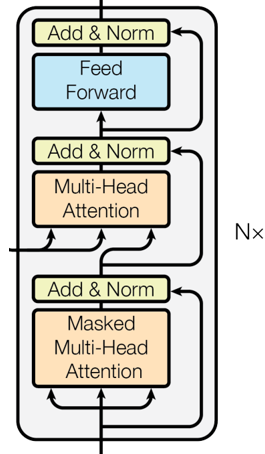

In [ ]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                              batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

To facilitate scaled dot-product operations
in the encoder-decoder attention
and addition operations in the residual connections,
[**the feature dimension (`num_hiddens`) of the decoder is
the same as that of the encoder.**]


In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

Now we [**construct the entire transformer decoder**]
composed of `num_layers` instances of `DecoderBlock`.
In the end,
a fully-connected layer computes the prediction
for all the `vocab_size` possible output tokens.
Both of the decoder self-attention weights
and the encoder-decoder attention weights
are stored for later visualization.


In [ ]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [ ]:
for X in train_iter:
    print (X)
    break

[tensor([[ 54,   5,   3,   1,   1,   1,   1,   1,   1,   1],
        [ 79,  34,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 17,  22,   4,   3,   1,   1,   1,   1,   1,   1],
        [113, 131,   0,   4,   3,   1,   1,   1,   1,   1],
        [117,   5,   3,   1,   1,   1,   1,   1,   1,   1],
        [ 42,   8,  11,   3,   1,   1,   1,   1,   1,   1],
        [165,  10,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 77,  21,   4,   3,   1,   1,   1,   1,   1,   1],
        [183,  10,  11,   3,   1,   1,   1,   1,   1,   1],
        [  0,   4,   3,   1,   1,   1,   1,   1,   1,   1],
        [ 83,  15,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 87,  22,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 41,  94,  11,   3,   1,   1,   1,   1,   1,   1],
        [  6,   0,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 99,  10,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 10,  20,   4,   3,   1,   1,   1,   1,   1,   1],
        [  9,  21,   4,   3,   1,   1, 

## Training

Let us instantiate an encoder-decoder model
by following the transformer architecture.
Here we specify that
both the transformer encoder and the transformer decoder
have 2 layers using 4-head attention.
Similar to :numref:`sec_seq2seq_training`,
we train the transformer model
for sequence to sequence learning on the English-French machine translation dataset.


In [ ]:
#this cell is added by myself
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
print(len(src_vocab))
print(len(tgt_vocab))

print(train_iter)

184
201


In [ ]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

#valid_lens = torch.tensor([3, 2])
#X=torch.ones((64, 10), dtype=torch.long)
#net(X).shape
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

TypeError: ignored

## Save the model for future inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/models/transformer.pth'


In [ ]:
#This will only save model parameters
torch.save(net.state_dict(), path)

## Load previously saved model

In [ ]:
net = d2l.EncoderDecoder(encoder, decoder)
net.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
net

EncoderDecoder(
  (encoder): TransformerEncoder(
    (embedding): Embedding(184, 32)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (blks): Sequential(
      (block0): EncoderBlock(
        (attention): MultiHeadAttention(
          (attention): DotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (W_q): Linear(in_features=32, out_features=32, bias=False)
          (W_k): Linear(in_features=32, out_features=32, bias=False)
          (W_v): Linear(in_features=32, out_features=32, bias=False)
          (W_o): Linear(in_features=32, out_features=32, bias=False)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): Linear(in_features=32, out_features=64, bias=True)
          (relu): ReLU()
          (dense2): Linear(in_features=64, ou

## Evaluation of Predicted Sequences

We can evaluate a predicted sequence
by comparing it with the
label sequence (the ground-truth).
BLEU (Bilingual Evaluation Understudy),
though originally proposed for evaluating
machine translation results :cite:`Papineni.Roukos.Ward.ea.2002`,
has been extensively used in measuring
the quality of output sequences for different applications.
In principle, for any $n$-grams in the predicted sequence,
BLEU evaluates whether this $n$-grams appears
in the label sequence.

Denote by $p_n$
the precision of $n$-grams,
which is
the ratio of
the number of matched $n$-grams in
the predicted and label sequences
to
the number of $n$-grams in the predicted sequence.
To explain,
given a label sequence $A$, $B$, $C$, $D$, $E$, $F$,
and a predicted sequence $A$, $B$, $B$, $C$, $D$,
we have $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, and $p_4 = 0$.
Besides,
let $\mathrm{len}_{\text{label}}$ and $\mathrm{len}_{\text{pred}}$
be
the numbers of tokens in the label sequence and the predicted sequence, respectively.
Then, BLEU is defined as

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$


where $k$ is the longest $n$-grams for matching.

Based on the definition of BLEU,
whenever the predicted sequence is the same as the label sequence, BLEU is 1.
Moreover,
since matching longer $n$-grams is more difficult,
BLEU assigns a greater weight
to a longer $n$-gram precision.
Specifically, when $p_n$ is fixed,
$p_n^{1/2^n}$ increases as $n$ grows (the original paper uses $p_n^{1/n}$).
Furthermore,
since
predicting shorter sequences
tends to obtain a higher $p_n$ value,
the coefficient before the multiplication term penalizes shorter predicted sequences.
For example, when $k=2$,
given the label sequence $A$, $B$, $C$, $D$, $E$, $F$ and the predicted sequence $A$, $B$,
although $p_1 = p_2 = 1$, the penalty factor $\exp(1-6/2) \approx 0.14$ lowers the BLEU.

We [**implement the BLEU measure**] as follows.

In [ ]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

After training,
we use the transformer model
to [**translate a few English sentences**] into French and compute their BLEU scores.


In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


Let us [**visualize the transformer attention weights**] when translating the last English sentence into French.
The shape of the encoder self-attention weights
is (number of encoder layers, number of attention heads, `num_steps` or number of queries, `num_steps` or number of key-value pairs).


In [ ]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

In the encoder self-attention,
both queries and keys come from the same input sequence.
Since padding tokens do not carry meaning,
with specified valid length of the input sequence,
no query attends to positions of padding tokens.
In the following,
two layers of multi-head attention weights
are presented row by row.
Each head independently attends
based on a separate representation subspaces of queries, keys, and values.


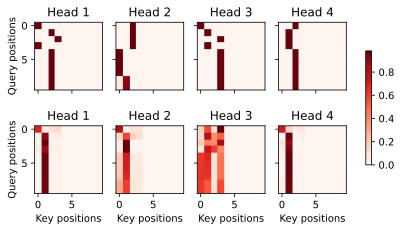

In [ ]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

[**To visualize both the decoder self-attention weights and the encoder-decoder attention weights,
we need more data manipulations.**]
For example,
we fill the masked attention weights with zero.
Note that
the decoder self-attention weights
and the encoder-decoder attention weights
both have the same queries:
the beginning-of-sequence token followed by
the output tokens.


In [ ]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

Due to the auto-regressive property of the decoder self-attention,
no query attends to key-value pairs after the query position.


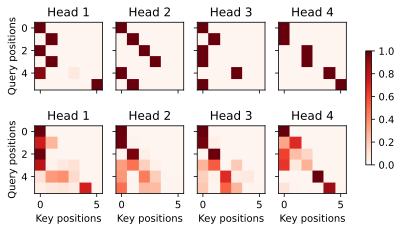

In [ ]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

Similar to the case in the encoder self-attention,
via the specified valid length of the input sequence,
[**no query from the output sequence
attends to those padding tokens from the input sequence.**]


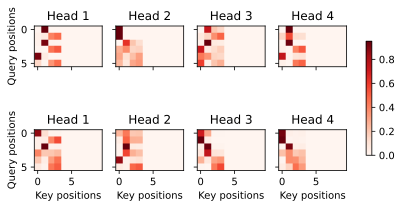

In [ ]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

Although the transformer architecture
was originally proposed for sequence-to-sequence learning,
as we will discover later in the book,
either the transformer encoder
or the transformer decoder
is often individually used
for different deep learning tasks.


## Summary

* The transformer is an instance of the encoder-decoder architecture, though either the encoder or the decoder can be used individually in practice.
* In the transformer, multi-head self-attention is used for representing the input sequence and the output sequence, though the decoder has to preserve the auto-regressive property via a masked version.
* Both the residual connections and the layer normalization in the transformer are important for training a very deep model.
* The positionwise feed-forward network in the transformer model transforms the representation at all the sequence positions using the same MLP.
